In [6]:
save_fig = false

NameError: name 'false' is not defined

In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from shapely.geometry import shape
import matplotlib.cm as cm
def read_geojson_manually(file_path):
    # Step 1: Read the GeoJSON file
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Step 2: Extract features
    features = data.get("features", [])
    if not features:
        raise ValueError("No features found in the GeoJSON file.")

    # Step 3: Parse geometries and properties
    geometries = []
    properties = []
    for feature in features:
        # Extract geometry
        geometry = feature.get("geometry")
        if geometry:
            try:
                geometries.append(shape(geometry))  # Convert to Shapely geometry
            except Exception as e:
                print(f"Error parsing geometry: {e}")
                geometries.append(None)
        else:
            geometries.append(None)

        # Extract properties
        properties.append(feature.get("properties", {}))

    # Step 4: Create a DataFrame for properties
    properties_df = pd.DataFrame(properties)

    # Step 5: Merge geometries and properties into a GeoDataFrame
    archetype = gpd.GeoDataFrame(properties_df, geometry=geometries, crs="EPSG:4326")

    return archetype
def thm2kwh(x):
    return x * 29.3
def kwh2thm(x):
    return x / 29.3
pv_efficiency = 0.16 # pv coverage (0.8) X pv cop (0.2)

/Users/lichengxuan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
archetype = gpd.read_file('BS_ref/archetype.geojson')
initial_guess = gpd.read_file('BS_ref/initial_guess.geojson')
prototype = gpd.read_file('BS_ref/prototype_building.geojson')

Skipping field Heating[KWh][Mth]: unsupported OGR type: 3
Skipping field Cooling[KWh][Mth]: unsupported OGR type: 3
Skipping field Equipment[KWh][Mth]: unsupported OGR type: 3
Skipping field Lighting[KWh][Mth]: unsupported OGR type: 3
Skipping field HotWater[KWh][Mth]: unsupported OGR type: 3
Skipping field GasEquipment[KWh][Mth]: unsupported OGR type: 3
Skipping field Auxiliary[KWh][Mth]: unsupported OGR type: 3
Skipping field Gas[kWh][Mth]: unsupported OGR type: 3
Skipping field Electricity[kWh][Mth]: unsupported OGR type: 3
Skipping field CO2[kg][Mth]: unsupported OGR type: 3
Skipping field CO2_Gas[kg][Mth]: unsupported OGR type: 3
Skipping field CO2_Electricity[kg][Mth]: unsupported OGR type: 3
Skipping field WWR_E_S_W_N_R_ESL: unsupported OGR type: 3
Skipping field Heating[KWh][Mth]: unsupported OGR type: 3
Skipping field Cooling[KWh][Mth]: unsupported OGR type: 3
Skipping field Equipment[KWh][Mth]: unsupported OGR type: 3
Skipping field Lighting[KWh][Mth]: unsupported OGR type: 3

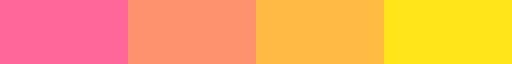

In [7]:
colors = plt.cm.spring(np.linspace(0.4, 0.9, 4))
from matplotlib.colors import ListedColormap
ListedColormap(colors)

In [8]:
import matplotlib.colors as mc

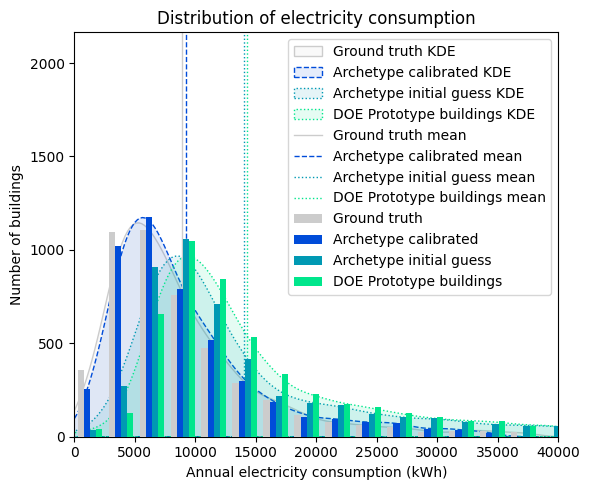

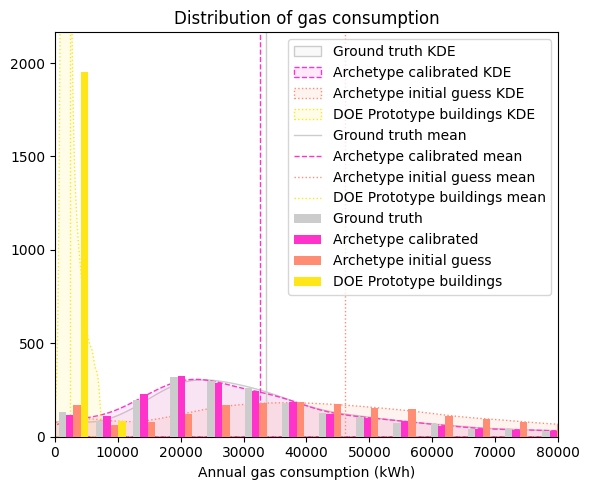

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Function for conversion (replace this with the actual function)
def thm2kwh(thm):
    return thm * 29.3  # Example conversion (therms to kWh)


Q = 0.9
colors = [[0.8, 0.8, 0.8, 1]] + plt.cm.winter(np.linspace(0.3, 0.9, 3)).tolist()

# Define the datasets (post-calibration)
calibrated_electricity = archetype['Electricity[kWh][Yr]'][archetype['Electricity[kWh][Yr]'] < archetype['Electricity[kWh][Yr]'].quantile(Q)]
billed_electricity = archetype['el_annual_2020'][archetype['el_annual_2020'] < archetype['el_annual_2020'].quantile(Q)]
calibrated_gas = archetype['Gas[kWh][Yr]'][archetype['Gas[kWh][Yr]'] < archetype['Gas[kWh][Yr]'].quantile(Q)]
billed_gas = archetype['gs_annual_2020'].apply(thm2kwh).fillna(0)
billed_gas = billed_gas[billed_gas < billed_gas.quantile(Q)]

# Define the datasets (pre-calibration)
calibrated_electricity_pre = initial_guess['Electricity[kWh][Yr]'][initial_guess['Electricity[kWh][Yr]'] < initial_guess['Electricity[kWh][Yr]'].quantile(Q)]
calibrated_gas_pre = initial_guess['Gas[kWh][Yr]'][initial_guess['Gas[kWh][Yr]'] < initial_guess['Gas[kWh][Yr]'].quantile(Q)]

prototype_electricity = prototype['Electricity[kWh][Yr]'][prototype['Electricity[kWh][Yr]'] < prototype['Electricity[kWh][Yr]'].quantile(Q)]
prototype_gas = prototype['Gas[kWh][Yr]'][prototype['Gas[kWh][Yr]'] < prototype['Gas[kWh][Yr]'].quantile(Q)]

# Define shared bins
bins = 20

# Electricity bins
min_elec = min(calibrated_electricity.min(), billed_electricity.min(), calibrated_electricity_pre.min(), prototype_electricity.min())
max_elec = max(calibrated_electricity.max(), billed_electricity.max(), calibrated_electricity_pre.max(), prototype_electricity.max())
bin_edges_elec = np.linspace(min_elec, max_elec, bins + 1)

# Gas bins
min_gas = min(calibrated_gas.min(), billed_gas.min(), calibrated_gas_pre.min(), prototype_gas.min())
max_gas = max(calibrated_gas.max(), billed_gas.max(), calibrated_gas_pre.max(), prototype_gas.max())
bin_edges_gas = np.linspace(min_gas, max_gas, bins + 1)

# Compute histogram counts
simulated_elec_counts, _ = np.histogram(calibrated_electricity, bins=bin_edges_elec, density=True)
billed_elec_counts, _ = np.histogram(billed_electricity, bins=bin_edges_elec, density=True)
simulated_elec_pre_counts, _ = np.histogram(calibrated_electricity_pre, bins=bin_edges_elec, density=True)
prototype_elec_counts, _ = np.histogram(prototype_electricity, bins=bin_edges_elec, density=True)

calibrated_gas_counts, _ = np.histogram(calibrated_gas, bins=bin_edges_gas, density=True)
billed_gas_counts, _ = np.histogram(billed_gas, bins=bin_edges_gas, density=True)
calibrated_gas_pre_counts, _ = np.histogram(calibrated_gas_pre, bins=bin_edges_gas, density=True)
prototype_gas_counts, _ = np.histogram(prototype_gas, bins=bin_edges_gas, density=True)

# Define bin centers for alignment
bin_centers_elec = (bin_edges_elec[:-1] + bin_edges_elec[1:]) / 2
bin_centers_gas = (bin_edges_gas[:-1] + bin_edges_gas[1:]) / 2

# Define bar widths
bar_width_elec = (bin_edges_elec[1] - bin_edges_elec[0]) * 0.2
bar_width_gas = (bin_edges_gas[1] - bin_edges_gas[0]) * 0.2

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True, layout='tight')
axs = [ax]
# Electricity subplot
axs[0].bar(bin_centers_elec - 1.5 * bar_width_elec, billed_elec_counts, width=bar_width_elec, color=colors[0], label='Ground truth', zorder=10)
axs[0].bar(bin_centers_elec - 0.5 * bar_width_elec, simulated_elec_counts, width=bar_width_elec, color=colors[1], label='Archetype calibrated', zorder=10)
axs[0].bar(bin_centers_elec + 0.5 * bar_width_elec, simulated_elec_pre_counts, width=bar_width_elec, color=colors[2], label='Archetype initial guess',  zorder=10)

axs[0].bar(bin_centers_elec + 1.5 * bar_width_elec, prototype_elec_counts, width=bar_width_elec, color=colors[3], label='DOE Prototype buildings', zorder=10)

# KDE curves for electricity
sns.kdeplot(billed_electricity, color=colors[0], ax=axs[0], linewidth=1, label='Ground truth KDE', linestyle="solid", fill=True, alpha=0.1)
sns.kdeplot(calibrated_electricity, color=colors[1], ax=axs[0], linewidth=1, label='Archetype calibrated KDE', linestyle="dashed", fill=True, alpha=0.1)
sns.kdeplot(calibrated_electricity_pre, color=colors[2], ax=axs[0], linewidth=1, label='Archetype initial guess KDE', linestyle="dotted", fill=True, alpha=0.1)

sns.kdeplot(prototype_electricity, color=colors[3], ax=axs[0], linewidth=1, label='DOE Prototype buildings KDE', linestyle="dotted", fill=True, alpha=0.1)

axs[0].axvline(billed_electricity.mean(), color=colors[0], linewidth=1, linestyle="solid", label='Ground truth mean')
axs[0].axvline(calibrated_electricity.mean(), color=colors[1], linewidth=1, linestyle="dashed", label='Archetype calibrated mean')
axs[0].axvline(calibrated_electricity_pre.mean(), color=colors[2], linewidth=1, linestyle="dotted", label='Archetype initial guess mean')

axs[0].axvline(prototype_electricity.mean(), color=colors[3], linewidth=1, linestyle="dotted", label='DOE Prototype buildings mean')

axs[0].set_xlabel('Annual electricity consumption (kWh)')
axs[0].set_ylabel('Number of buildings')
axs[0].set_title('Distribution of electricity consumption')
axs[0].legend()
#axs[0].set_yticks(np.arange(0, 801, 100) / calibrated_electricity.shape[0], np.arange(0, 801, 100) )
axs[0].set_xlim(0, 40000)
axs[0].set_yticks(np.arange(0, 5001, 500) / calibrated_electricity.shape[0] / (bin_centers_elec[1] - bin_centers_elec[0]), np.arange(0, 5001, 500) )
axs[0].set_ylim(0, 0.9/5000)

if save_fig: plt.savefig('print/archetype_distribution_comparison_elec.png', bbox_inches='tight')
if save_fig: plt.savefig('print/archetype_distribution_comparison_elec.pdf', bbox_inches='tight')



# -------------------#




fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharey=True, layout='tight')
axs = [0, ax]
# Gas subplot
colors = colors[::-1]
colors = [[0.8, 0.8, 0.8, 1]] + plt.cm.spring(np.linspace(0.2, 0.9, 3)).tolist()
axs[1].bar(bin_centers_gas - 1.5 * bar_width_gas, billed_gas_counts, width=bar_width_gas, color=colors[0], label='Ground truth', zorder=10)
axs[1].bar(bin_centers_gas - 0.5 * bar_width_gas, calibrated_gas_counts, width=bar_width_gas, color=colors[1], label='Archetype calibrated', zorder=10)
axs[1].bar(bin_centers_gas + 0.5 * bar_width_gas, calibrated_gas_pre_counts, width=bar_width_gas, color=colors[2], label='Archetype initial guess', zorder=10)

axs[1].bar(bin_centers_gas + 1.5 * bar_width_gas, prototype_gas_counts, width=bar_width_gas, color=colors[3], label='DOE Prototype buildings', zorder=10)

# KDE curves for gas
sns.kdeplot(billed_gas, color=colors[0], ax=axs[1], linewidth=1, label='Ground truth KDE', linestyle="solid", fill=True, alpha=0.1)
sns.kdeplot(calibrated_gas, color=colors[1], ax=axs[1], linewidth=1, label='Archetype calibrated KDE', linestyle="dashed", fill=True, alpha=0.1)
sns.kdeplot(calibrated_gas_pre, color=colors[2], ax=axs[1], linewidth=1, label='Archetype initial guess KDE', linestyle="dotted", fill=True, alpha=0.1)

sns.kdeplot(prototype_gas, color=colors[3], ax=axs[1], linewidth=1, label='DOE Prototype buildings KDE', linestyle="dotted", fill=True, alpha=0.1)

axs[1].axvline(billed_gas.mean(), color=colors[0], linewidth=1, linestyle="solid", label='Ground truth mean')
axs[1].axvline(calibrated_gas.mean(), color=colors[1], linewidth=1, linestyle="dashed", label='Archetype calibrated mean')
axs[1].axvline(calibrated_gas_pre.mean(), color=colors[2], linewidth=1, linestyle="dotted", label='Archetype initial guess mean')

axs[1].axvline(prototype_gas.mean(), color=colors[3], linewidth=1, linestyle="dotted", label='DOE Prototype buildings mean')

axs[1].set_xlabel('Annual gas consumption (kWh)')
axs[1].set_title('Distribution of gas consumption')
axs[1].legend()

axs[1].set_xlim(0, 80000)

axs[1].set_yticks([], [])


#axs[1].set_yticks(np.arange(0, 2601, 200) / calibrated_electricity.shape[0] / (bin_centers_gas[1] - bin_centers_gas[0]), [] )
axs[1].set_yticks(np.arange(0, 5001, 500) / calibrated_electricity.shape[0] / (bin_centers_elec[1] - bin_centers_elec[0]), np.arange(0, 5001, 500) )
axs[1].set_ylim(0, 0.9/5000)

axs[1].set_ylabel('')
#fig.suptitle('Distribution of pre- and post-calibration simulation and billed energy consumption')
plt.tight_layout()


if save_fig: plt.savefig('print/archetype_distribution_comparison_gas.png', bbox_inches='tight')
if save_fig: plt.savefig('print/archetype_distribution_comparison_gas.pdf', bbox_inches='tight')